In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

# 示例句子
text1 = "Parses the given JSON and returns eit a JSONObject or a JSONArry an exit"
text2 = "Parses the given JSON and returns either a JSONObject or a JSONArray"

# 将句子转换为词袋模型
vectorizer = CountVectorizer(binary=True)
count_matrix = vectorizer.fit_transform([text1, text2]).toarray()

# 计算Jaccard相似度
jaccard_sim = jaccard_score(count_matrix[0], count_matrix[1])
print(jaccard_sim)

0.5714285714285714


In [2]:
import torch
import pandas as pd
import numpy as np

def retrieve_train_data():
    train_param = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/param/train.json")
    train_return = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/return/train.json")
    train_summary = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/summary/train.json")
    train_df = pd.concat([train_summary,train_param, train_return], axis=0)
    train_df = train_df.reset_index(drop=True)
    return train_df
def retrieve_valid_data():
    valid_param = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/param/valid.json")
    valid_return = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/return/valid.json")
    valid_summary = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/summary/valid.json")
    valid_df = pd.concat([valid_summary,valid_param, valid_return ], axis=0)
    valid_df = valid_df.reset_index(drop=True)
    return valid_df
def retrieve_test_data():
    test_param = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/param/test.json")
    test_return = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/return/test.json")
    test_summary = pd.read_json("D:/BERT_learing/code_comment_inconsistency_detection/data/summary/test.json")
    test_df = pd.concat([test_summary,test_param, test_return], axis=0)
    test_df = test_df.reset_index(drop=True)
    return test_df
train_df = retrieve_train_data()
valid_df = retrieve_valid_data()
test_df = retrieve_test_data()

In [3]:
len(train_df)

32988

In [4]:
# 1 为 不一致
# 0 为 一致
list_old_comment = [train_df.loc[i]['old_comment_raw']for i in train_df.index[train_df['label'] == 1].tolist()]
list_new_comment = [train_df.loc[i]['new_comment_raw']for i in train_df.index[train_df['label'] == 1].tolist()]

In [5]:
list_old_comment[:5]

['Parses the given JSON and returns ether a JSONObject or a JSONArry',
 'Creates a new  CounterMetric and registers it under the given class and name.',
 'Revert a rotation/rotation rate pair.',
 'Retrieves the ColumnDefinition corresponding to the specified raw ColumnIdentifier.',
 'Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.']

In [6]:
list_new_comment[:5]

['Parses the given JSON and returns either a JSONObject or a JSONArray',
 'Creates a new  com.yammer.metrics.core.Counter and registers it under the given class and name.',
 'Revert a rotation/rotation rate/ rotation acceleration triplet.',
 'Retrieves the ColumnMetadata corresponding to the specified raw ColumnIdentifier.',
 'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.']

In [7]:
len(list_old_comment)

16494

先统计一下不一致的相似度是多少

In [8]:
list_old_comment = list_old_comment[:20]
list_new_comment = list_new_comment[:20]

In [9]:
len(list_old_comment)

20

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

# 非动态 仅以 0.8 作为过滤标准
def get_similarity_jaccard_score(list_old, list_new):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
        
    for old, new in zip(list_old, list_new):
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])

        if similarity > 0.8 :
            count = count + 1
            text_similarity.append([old,new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old,new])
            similarity_word_inconsistency.append(similarity)
    print(f'jaccard相似度大于0.8的有 : {count} 个')
    return text_similarity,similarity_inconsistency,text_word_similarity,similarity_word_inconsistency

In [11]:
text_above8_similarity,similarity_above8_inconsistency,text_below8_similarity,similarity_below8_inconsistency\
= get_similarity_jaccard_score(list_old_comment,list_new_comment)

jaccard相似度大于0.8的有 : 1 个


In [12]:
mean_inconsisency = np.mean(similarity_above8_inconsistency)
mean_inconsisency

0.8888888888888888

In [13]:
mean_inconsisency = np.mean(similarity_below8_inconsistency)
mean_inconsisency

0.5334611037397414

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score


# 动态 较短的注释设置较高的阈值，而对较长的注释设置较低的阈值，可以通过注释的长度反比例调整阈值。
# 这样可以保证短注释需要更严格的相似度，而长注释允许较宽松的匹配标准。
def get_similarity_jaccard_score_length_adjusted_threshold(list_old, list_new, min_threshold=0.6, max_threshold=1.0):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
    
    for old, new in zip(list_old, list_new):
        # 获取旧注释的词汇数
        old_word_count = len(old.split())
        
        # 动态设置阈值，较短注释的阈值更高，较长注释的阈值更低
        dynamic_threshold = min_threshold + (max_threshold - min_threshold) * (1 / old_word_count)
        
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])
        
#         print(f'动态阈值为: {dynamic_threshold} ')

        if similarity >= dynamic_threshold:
            count += 1
            text_similarity.append([old, new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old, new])
            similarity_word_inconsistency.append(similarity)

    print(f'Jaccard 相似度大于动态阈值的有: {count} 个')
    return text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency

In [15]:
list_old_comment = [train_df.loc[i]['old_comment_raw']for i in train_df.index[train_df['label'] == 1].tolist()]
list_new_comment = [train_df.loc[i]['new_comment_raw']for i in train_df.index[train_df['label'] == 1].tolist()]

In [16]:
text_abovethreshold_similarity,similarity_abovethreshold_inconsistency,\
text_belowthreshold_similarity,similarity_belowthreshold_inconsistency\
= get_similarity_jaccard_score_length_adjusted_threshold(list_old_comment,list_new_comment)

Jaccard 相似度大于动态阈值的有: 7847 个


In [17]:
mean_inconsisency = np.mean(similarity_abovethreshold_inconsistency)
mean_inconsisency

0.7980160981229073

In [18]:
len(text_abovethreshold_similarity)

7847

In [19]:
len(similarity_belowthreshold_inconsistency)

8647

In [20]:
mean_inconsisency = np.mean(similarity_belowthreshold_inconsistency)
mean_inconsisency

0.39292091917542554

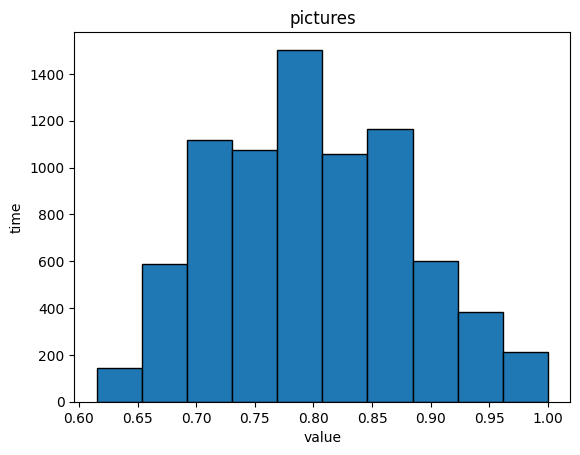

In [21]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(similarity_abovethreshold_inconsistency, bins=10, edgecolor='black')
plt.xlabel("value")
plt.ylabel("time")
plt.title("pictures")
plt.show()

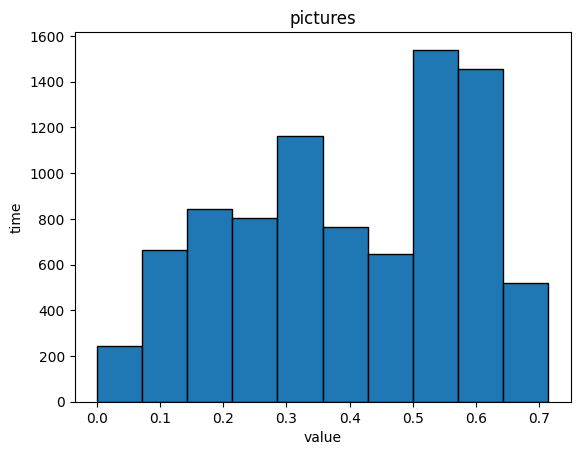

In [22]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(similarity_belowthreshold_inconsistency, bins=10, edgecolor='black')
plt.xlabel("value")
plt.ylabel("time")
plt.title("pictures")
plt.show()

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

def get_similarity_jaccard_score_proportional_threshold(list_old, list_new, base_threshold=0.6, scaling_factor=0.05):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
    
    for old, new in zip(list_old, list_new):
        # 获取新旧注释的词汇长度
        old_len = len(old.split())
        new_len = len(new.split())
     
        # 根据新旧注释长度差值来调整阈值
        if old_len > new_len:
            length_diff = new_len - old_len
            dynamic_threshold  = base_threshold + scaling_factor * length_diff
        else:
            length_diff = old_len - new_len
            dynamic_threshold  = base_threshold + scaling_factor * length_diff
        
#         print(f'动态阈值为: {dynamic_threshold} ')
        
        # 计算 Jaccard 相似度
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])

        # 判断是否满足相似度阈值条件
        if similarity >= dynamic_threshold:
            count += 1
            text_similarity.append([old, new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old, new])
            similarity_word_inconsistency.append(similarity)

    print(f'Jaccard 相似度大于动态阈值的有: {count} 个')
    return text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency

# 使用动态阈值方法，设定基础阈值为 0.6，比例增量为 0.05
text_abovethreshold_similarity_2,similarity_abovethreshold_inconsistency_2,\
text_belowthreshold_similarity_2,similarity_belowthreshold_inconsistency_2\
= get_similarity_jaccard_score_proportional_threshold(list_old_comment,list_new_comment)

Jaccard 相似度大于动态阈值的有: 12075 个


In [24]:
mean_inconsisency = np.mean(similarity_abovethreshold_inconsistency_2)
mean_inconsisency

0.68940617521928

In [25]:
len(text_abovethreshold_similarity_2)

12075

In [26]:
len(similarity_belowthreshold_inconsistency_2)

4419

In [27]:
mean_inconsisency = np.mean(similarity_belowthreshold_inconsistency_2)
mean_inconsisency

0.30211358775911973

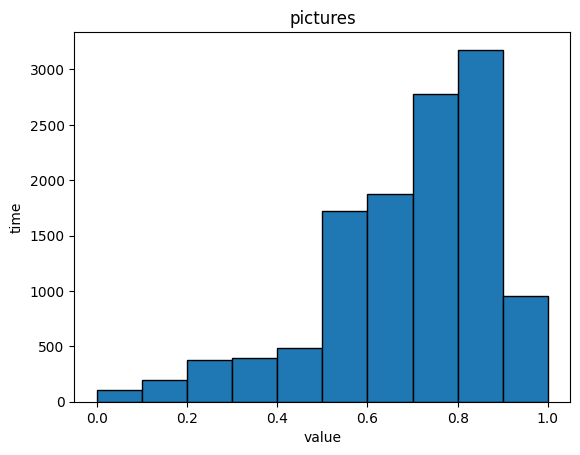

In [28]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(similarity_abovethreshold_inconsistency_2, bins=10, edgecolor='black')
plt.xlabel("value")
plt.ylabel("time")
plt.title("pictures")
plt.show()

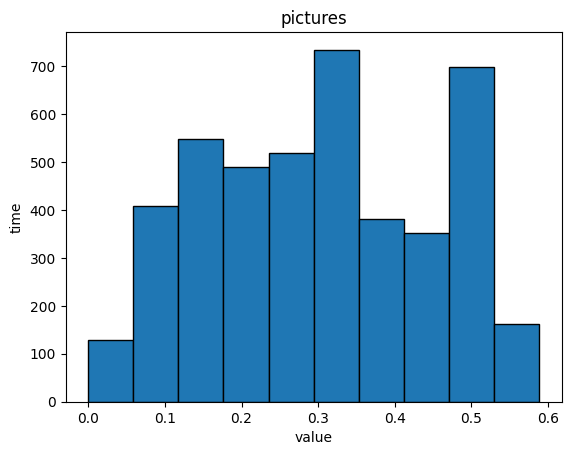

In [29]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(similarity_belowthreshold_inconsistency_2, bins=10, edgecolor='black')
plt.xlabel("value")
plt.ylabel("time")
plt.title("pictures")
plt.show()

In [30]:
from sentence_transformers import SentenceTransformer, util

# 加载Sentence-BERT模型
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

D:\anaconda\envs\leitx\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
D:\anaconda\envs\leitx\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
def get_similarity_Sentence_BERT_test(model, list_word):
    similarity_list_inconsistency = []
    
    for i in range(0, len(list_word)):
        batch_old = list_word[i][0]
        batch_new = list_word[i][1]
        
        embedding1 = model.encode(batch_old, convert_to_tensor=True)
        embedding2 = model.encode(batch_new, convert_to_tensor=True)
        
        similarity = util.pytorch_cos_sim(embedding1, embedding2)
        similarity_list_inconsistency.extend([similarity.item()])
    
    return similarity_list_inconsistency

In [32]:
similarity_list_inconsisency_Bert = get_similarity_Sentence_BERT_test(model,text_below8_similarity)

In [33]:
similarity_threshold_inconsisency_Bert = get_similarity_Sentence_BERT_test(model,text_belowthreshold_similarity)
mean_inconsisency = np.mean(similarity_threshold_inconsisency_Bert)
mean_inconsisency

0.7018726832163684

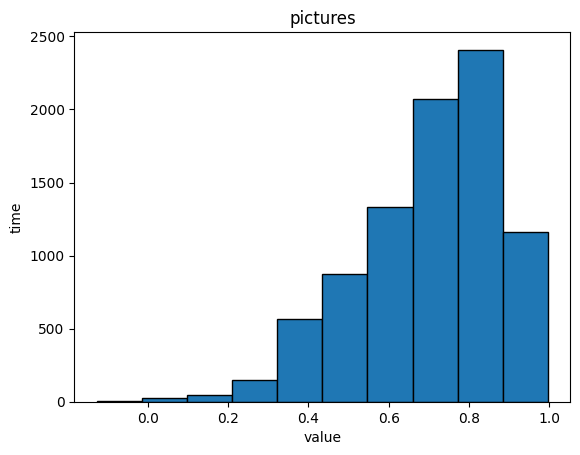

In [34]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(similarity_threshold_inconsisency_Bert, bins=10, edgecolor='black')
plt.xlabel("value")
plt.ylabel("time")
plt.title("pictures")
plt.show()

In [35]:
def get_similarity_Sentence_BERT(model, list_word):
    
    similarity_inconsistency_filter = []
    similarity_inconsistency_result = []
    
    text_filter = []
    text_result = []
    
    count = 0

    for i in range(0, len(list_word)):
        batch_old = list_word[i][0]
        batch_new = list_word[i][1]
        
        embedding1 = model.encode(batch_old, convert_to_tensor=True)
        embedding2 = model.encode(batch_new, convert_to_tensor=True)
        
        similarity = util.pytorch_cos_sim(embedding1, embedding2)
        # 大于0.8 过滤掉
        if similarity.item() > 0.9:
            count += 1
            text_filter.append(list_word[i])
            similarity_inconsistency_filter.extend([similarity.item()])
        else:          
            text_result.append(list_word[i])
            similarity_inconsistency_result.extend([similarity.item()])
    print(f'大于阈值的有: {count} 个')
    return text_result,similarity_inconsistency_result,text_filter,similarity_inconsistency_filter

In [36]:
text_result,similarity_inconsistency_result,text_filter,similarity_inconsistency_filter\
= get_similarity_Sentence_BERT(model,text_belowthreshold_similarity)

大于阈值的有: 799 个


In [37]:
len(text_belowthreshold_similarity)

8647

In [38]:
len(text_result)

7848

In [39]:
text_filter[:10]

[['Removes the variable.',
  'Removes the variable and returns the removed value.'],
 ['If I was able to use a  CacheEntity to response to the  HttpRequest then generate an  HttpResponse based on the cache entry.',
  'If it is legal to use cached content in response response to the  HttpRequest then generate an  HttpResponse based on  HttpCacheEntry.'],
 ["Get the work directory of the current schedule 'workdir'/'project'/'schedule' ",
  "Gets the work directory of this schedule 'workdir'/'project'/'schedule'."],
 ['dispatch plan creation based on analysis type',
  'dispatch plan creation based on analyzed statement'],
 ['Build an instance of MongoClientOptions.',
  'Build an instance of  MongoClientSettings.'],
 ['Gets list edit part.', 'Gets list edit parts.'],
 ['Sends a request to the elasticsearch cluster that the current client points to and waits for the corresponding response to be returned.',
  'Sends a request to the elasticsearch cluster that the current client points to.'],

In [40]:
similarity_inconsistency_filter[:10]

[0.9048896431922913,
 0.9076058864593506,
 0.945710301399231,
 0.9435141682624817,
 0.9386283159255981,
 0.9413950443267822,
 0.9370062947273254,
 0.9536461234092712,
 0.9508100748062134,
 0.910328209400177]

In [41]:
text_filter[10:20]

[['Check DataBlockEncodings for column families.',
  'Check DataBlockEncodings of column families are compatible.'],
 ['Get singleton  UserTransaction lazily.',
  'Get singleton  UserTransactionManager lazily.'],
 ['Removes the w s r p consumer from the database.',
  'Removes the w s r p consumer with the primary key from the database.'],
 ['calculate the variance-covariance matrix, treat each point as a sample',
  'Calculates the variance-covariance matrix of a set of points.'],
 ["Begin a load with Glide that will be tied to the given  android.support.v4.app.Fragment's lifecycle and that uses the given  android.support.v4.app.Fragment's default options.",
  'Begin a load with Glide that will be tied to the lifecycle of the  Fragment,  android.app.Fragment, or  Activity that contains the View.'],
 ["Changes this user's password asynchronously.",
  "Changes another user's password asynchronously."],
 ['Convenience method to mkdirs recursively.',
  'Convenience method for mkdirs with re

In [42]:
similarity_inconsistency_filter[10:20]

[0.9474596977233887,
 0.9586507081985474,
 0.9039474725723267,
 0.9057900905609131,
 0.9029049873352051,
 0.9636608958244324,
 0.9306247234344482,
 0.9488253593444824,
 0.935778021812439,
 0.9516746997833252]

In [119]:
len(text_filter)

799

In [120]:
np.mean(similarity_inconsistency_filter)

0.934692248012008

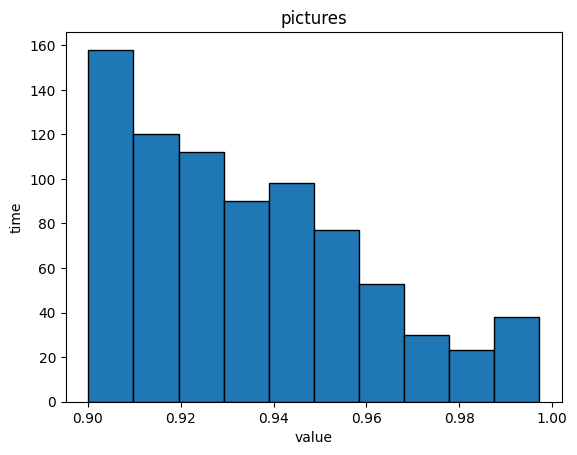

In [121]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(similarity_inconsistency_filter, bins=10, edgecolor='black')
plt.xlabel("value")
plt.ylabel("time")
plt.title("pictures")
plt.show()

剩余数据的个数为  len(text_abovethreshold_similarity) + len(text_result)

In [122]:
len(list_old_comment),len(text_abovethreshold_similarity),len(text_result)

(16494, 7847, 7848)

In [123]:
text_result_2,similarity_inconsistency_result_2,text_filter_2,similarity_inconsistency_filter_2\
= get_similarity_Sentence_BERT(model,text_belowthreshold_similarity_2)

大于阈值的有: 217 个


In [130]:
text_filter_2[:10]

[['If I was able to use a  CacheEntity to response to the  HttpRequest then generate an  HttpResponse based on the cache entry.',
  'If it is legal to use cached content in response response to the  HttpRequest then generate an  HttpResponse based on  HttpCacheEntry.'],
 ['dispatch plan creation based on analysis type',
  'dispatch plan creation based on analyzed statement'],
 ['Get the character conversion data for a given key code.',
  'Get the characters conversion data for a given keyCode.'],
 ['calculate the variance-covariance matrix, treat each point as a sample',
  'Calculates the variance-covariance matrix of a set of points.'],
 ["Begin a load with Glide that will be tied to the given  android.support.v4.app.Fragment's lifecycle and that uses the given  android.support.v4.app.Fragment's default options.",
  'Begin a load with Glide that will be tied to the lifecycle of the  Fragment,  android.app.Fragment, or  Activity that contains the View.'],
 ['Convenience method to mkdir

In [131]:
similarity_inconsistency_filter_2[:10]

[0.9076058864593506,
 0.9435141682624817,
 0.9508100748062134,
 0.9057900905609131,
 0.9029049873352051,
 0.9306247234344482,
 0.9595814347267151,
 0.9611199498176575,
 0.9280614256858826,
 0.951404869556427]

In [124]:
len(text_result_2)

4202

In [125]:
len(text_filter_2)

217

剩余数据的个数为  len(text_abovethreshold_similarity_2) + len(text_result_2)

In [127]:
# train
len(list_old_comment),len(text_abovethreshold_similarity_2),len(text_result_2)

(16494, 12075, 4202)

valid

In [202]:
# 1 为 不一致
# 0 为 一致
list_old_comment_valid = [valid_df.loc[i]['old_comment_raw']for i in valid_df.index[valid_df['label'] == 1].tolist()]
list_new_comment_valid = [valid_df.loc[i]['new_comment_raw']for i in valid_df.index[valid_df['label'] == 1].tolist()]

In [203]:
# valid
text_abovethreshold_similarity_valid,similarity_abovethreshold_inconsistency_valid,\
text_belowthreshold_similarity_valid,similarity_belowthreshold_inconsistency_valid\
= get_similarity_jaccard_score_proportional_threshold(list_old_comment_valid,list_new_comment_valid)

Jaccard 相似度大于动态阈值的有: 1321 个


In [204]:
text_result_valid,similarity_inconsistency_result_valid,text_filter_valid,similarity_inconsistency_filter_valid\
= get_similarity_Sentence_BERT(model,text_belowthreshold_similarity_valid)

大于阈值的有: 41 个


In [205]:
len(list_old_comment_valid),len(text_abovethreshold_similarity_valid),len(text_result_valid)

(1878, 1321, 516)

test

In [206]:
# 1 为 不一致
# 0 为 一致
list_old_comment_test = [test_df.loc[i]['old_comment_raw']for i in test_df.index[test_df['label'] == 1].tolist()]
list_new_comment_test = [test_df.loc[i]['new_comment_raw']for i in test_df.index[test_df['label'] == 1].tolist()]

In [207]:
# valid
text_abovethreshold_similarity_test,similarity_abovethreshold_inconsistency_test,\
text_belowthreshold_similarity_test,similarity_belowthreshold_inconsistency_test\
= get_similarity_jaccard_score_proportional_threshold(list_old_comment_test,list_new_comment_test)

Jaccard 相似度大于动态阈值的有: 1429 个


In [208]:
text_result_test,similarity_inconsistency_result_test,text_filter_test,similarity_inconsistency_filter_test\
= get_similarity_Sentence_BERT(model,text_belowthreshold_similarity_test)

大于阈值的有: 17 个


In [209]:
len(list_old_comment_test),len(text_abovethreshold_similarity_test),len(text_result_test)

(1972, 1429, 526)

SATD数量

In [187]:
def get_SATD_index(list_old):
    SATD_index = []
    for i in range(0,len(list_old)):
        if list_old[i] == 'DOCUMENT ME!':
            SATD_index.append(i)
    return SATD_index

In [188]:
# train_data
# 1 为 不一致
# 0 为 一致
list_old_comment = train_df['old_comment_raw'].to_list()
list_new_comment = train_df['new_comment_raw'].to_list()

In [189]:
SATD_index_train_old =get_SATD_index(list_old_comment)
SATD_index_train_old

[]

In [190]:
SATD_index_train_new =get_SATD_index(list_new_comment)
SATD_index_train_new

[]

In [198]:
# valid_data
# 1 为 不一致
# 0 为 一致
list_old_comment_valid = valid_df['old_comment_raw'].to_list() 
list_new_comment_valid = valid_df['new_comment_raw'].to_list() 

In [199]:
SATD_index_valid_old =get_SATD_index(list_old_comment_valid)
SATD_index_valid_old

[38,
 119,
 136,
 174,
 176,
 190,
 192,
 196,
 238,
 259,
 307,
 319,
 337,
 445,
 447,
 455,
 492,
 506,
 575,
 577,
 590,
 622,
 672,
 699,
 717,
 721,
 736,
 745,
 747,
 757,
 768,
 824,
 878,
 934,
 980,
 1000,
 1004,
 1012,
 1019,
 1021,
 1028]

In [200]:
len(SATD_index_valid_old)

41

In [193]:
SATD_index_train_new =get_SATD_index(list_new_comment_valid)
SATD_index_train_new

[]

In [194]:
# test_data
# 1 为 不一致
# 0 为 一致
list_old_comment_test = test_df['old_comment_raw'].to_list() 
list_new_comment_test = test_df['new_comment_raw'].to_list() 

In [197]:
SATD_index_test_old =get_SATD_index(list_old_comment_test)
SATD_index_test_old

[63,
 98,
 102,
 116,
 134,
 136,
 138,
 180,
 190,
 250,
 289,
 291,
 297,
 349,
 361,
 367,
 407,
 443,
 477,
 516,
 558,
 667,
 673,
 723,
 772,
 785,
 807,
 842,
 874,
 886,
 922,
 1019,
 1032,
 1045,
 1050,
 1059]

In [201]:
len(SATD_index_test_old)

36

In [196]:
SATD_index_test_new =get_SATD_index(list_new_comment_test)
SATD_index_test_new

[]

未完成注释

In [219]:
def get_comment_len(list_old):
    len_index = []
    for i in range(0,len(list_old)):
        old_len = len(list_old[i].split())
        if old_len == 1:
            len_index.append(i)
    return len_index

17个

In [220]:
num_index_train_old =get_comment_len(list_old_comment)
num_index_train_old,len(num_index_train_old)

([648, 2182, 3023, 3427, 4006, 5139, 6812, 7294, 8110], 9)

In [221]:
num_index_train_new =get_comment_len(list_new_comment)
num_index_train_new,len(num_index_train_new)

([86, 648, 2182, 2567, 4006, 4911, 6696, 6812], 8)

6个

In [222]:
num_index_valid_old =get_comment_len(list_old_comment_valid)
num_index_valid_old,len(num_index_valid_old)

([25, 60, 202, 361, 478], 5)

In [223]:
num_index_train_new =get_comment_len(list_new_comment_valid)
num_index_train_new,len(num_index_train_new)

([186], 1)

6个

In [224]:
num_index_test_old =get_comment_len(list_old_comment_test)
num_index_test_old,len(num_index_test_old)

([3, 63, 350, 404, 494], 5)

In [225]:
num_index_test_new =get_comment_len(list_new_comment_test)
num_index_test_new,len(num_index_test_new)

([131], 1)

动态阈值一

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

def get_similarity_jaccard_score_dynamic_threshold(list_old, list_new, change_ratio=0.3):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
        
    for old, new in zip(list_old, list_new):
        # 计算每个注释的词汇数
        old_word_count = len(old.split())
        
        # 动态设定阈值，根据允许的词汇变化比例调整
        allowed_changes = int(old_word_count * change_ratio)
        threshold = (old_word_count - allowed_changes) / old_word_count
        print(f'动态阈值为: {threshold} ')

        # 计算Jaccard相似度
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])

        if similarity >= threshold:
            count += 1
            text_similarity.append([old, new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old, new])
            similarity_word_inconsistency.append(similarity)

    print(f'Jaccard 相似度大于动态阈值的有: {count} 个')
    return text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency

# 示例调用
list_old = ["Parses the given JSON and returns a JSONObject", 
            "Parses the given JSON and returns a JSONArray"]
list_new = ["Parses the given JSON and returns either a JSONObject", 
            "Parses the given JSON and returns an JSONObject"]

# 使用动态阈值方法，允许 10% 的词汇变化
text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency \
= get_similarity_jaccard_score_dynamic_threshold(list_old, list_new, change_ratio=0.1)

动态阈值为: 1.0 
动态阈值为: 1.0 
Jaccard 相似度大于动态阈值的有: 0 个


In [51]:
text_similarity

[]

In [52]:
text_word_similarity

[['Parses the given JSON and returns a JSONObject',
  'Parses the given JSON and returns either a JSONObject'],
 ['Parses the given JSON and returns a JSONArray',
  'Parses the given JSON and returns an JSONObject']]

每对注释的 Jaccard 相似度会与其动态计算的阈值进行比较，使得阈值依据注释长度自动调整，避免短句和长句的过滤标准不一致的问题。

下面两个是
可以通过新旧注释长度的相对变化来确定相似度阈值。比如，如果新注释与旧注释的长度相差不大（仅改动了少量词汇），可以设置较高的相似度阈值；如果长度差距较大，则设定较低的阈值来反映更宽松的匹配条件。
</br>后一个对

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

def get_similarity_jaccard_score_length_based_threshold(list_old, list_new, base_threshold=0.85):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
        
    for old, new in zip(list_old, list_new):
        # 获取新旧注释的词汇数
        old_word_count = len(old.split())
        new_word_count = len(new.split())
        
        # 根据长度差异动态调整阈值
        length_ratio = min(old_word_count, new_word_count) / max(old_word_count, new_word_count)
        dynamic_threshold = base_threshold * length_ratio
        print(f'动态阈值为: {dynamic_threshold} ')
        
        # 计算 Jaccard 相似度
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])

        # 判断是否满足相似度阈值条件
        if similarity >= dynamic_threshold:
            count += 1
            text_similarity.append([old, new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old, new])
            similarity_word_inconsistency.append(similarity)

    print(f'Jaccard 相似度大于动态阈值的有: {count} 个')
    return text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency

# 示例调用
list_old = ["Parses the given JSON and returns a JSONObject", 
            "Parses the given JSON and returns a JSONArray",
            'Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
            #"The cat is on the mat."
           ]
list_new = ["Parses the given JSON and returns either a JSONObject", 
            "Parses the given JSON and returns a JSONObject",
            'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
            #"There is a feline on the rug."
           ]

# 使用动态阈值方法，设定基础阈值为 0.85
text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency = get_similarity_jaccard_score_length_based_threshold(list_old, list_new, base_threshold=0.85)


动态阈值为: 0.7555555555555555 
动态阈值为: 0.85 
动态阈值为: 0.85 
Jaccard 相似度大于动态阈值的有: 1 个


In [54]:
text_similarity

[['Parses the given JSON and returns a JSONObject',
  'Parses the given JSON and returns either a JSONObject']]

In [55]:
text_word_similarity

[['Parses the given JSON and returns a JSONArray',
  'Parses the given JSON and returns a JSONObject'],
 ['Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
  'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.']]

min_threshold 和 max_threshold 分别表示最小和最大相似度阈值。</br>
dynamic_threshold = min_threshold + (max_threshold - min_threshold) * (1 / old_word_count)：较短的注释会得到更高的动态阈值，而较长的注释会得到相对较低的阈值。</br>
similarity >= dynamic_threshold：对比每对注释的相似度和动态计算的阈值，判断是否满足条件。</br>
这样设定可以确保短注释需要较高的相似度以通过过滤，而长注释则有更宽松的匹配标准，从而适应注释长度差异带来的语义变化。</br>
这个对

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import math

def get_similarity_jaccard_score_length_adjusted_threshold(list_old, list_new, min_threshold=0.6, max_threshold=1.0):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
    
    for old, new in zip(list_old, list_new):
        # 获取旧注释的词汇数
        old_word_count = len(old.split())
        
        # 动态设置阈值，较短注释的阈值更高，较长注释的阈值更低
        dynamic_threshold = min_threshold + (max_threshold - min_threshold) * (1 / old_word_count)
        
        # 计算 Jaccard 相似度
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])
        print(f'动态阈值为: {dynamic_threshold} ')

        # 判断是否满足相似度阈值条件
        if similarity >= dynamic_threshold:
            count += 1
            text_similarity.append([old, new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old, new])
            similarity_word_inconsistency.append(similarity)

    print(f'Jaccard 相似度大于动态阈值的有: {count} 个')
    return text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency

# 示例调用
list_old = ["Parses the given JSON and returns a JSONObject", 
            "Parses the given JSON and returns a JSONArray",
            'Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
            "The cat is on the mat.",
            'Decodes the input  ByteBuf into a  RPCBlockWriteResponse object and returns it.'
           ]
list_new = ["Parses the given JSON and returns either a JSONObject", 
            "Parses the given JSON and returns a JSONObject",
            'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
            "There is a feline on the rug.",
            'Decode the input  ByteBuf into a  RPCBlockWriteResponse object and return it.'
           ]


# 使用动态阈值方法，设置最小阈值为 0.6，最大阈值为 0.9
text_above8_similarity,similarity_above8_inconsistency,text_below8_similarity,similarity_below8_inconsistency\
= get_similarity_jaccard_score_length_adjusted_threshold(
    list_old, list_new, min_threshold=0.6, max_threshold=1.0)


动态阈值为: 0.7414213562373095 
动态阈值为: 0.7414213562373095 
动态阈值为: 0.6852802865422442 
动态阈值为: 0.7632993161855453 
动态阈值为: 0.7206045378311055 
Jaccard 相似度大于动态阈值的有: 3 个


In [114]:
text_above8_similarity

[['Parses the given JSON and returns a JSONObject',
  'Parses the given JSON and returns either a JSONObject'],
 ['Parses the given JSON and returns a JSONArray',
  'Parses the given JSON and returns a JSONObject'],
 ['Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
  'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.']]

In [115]:
similarity_above8_inconsistency

[0.875, 0.75, 0.75]

In [116]:
text_below8_similarity

[['The cat is on the mat.', 'There is a feline on the rug.'],
 ['Decodes the input  ByteBuf into a  RPCBlockWriteResponse object and returns it.',
  'Decode the input  ByteBuf into a  RPCBlockWriteResponse object and return it.']]

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

def get_similarity_jaccard_score_proportional_threshold(list_old, list_new, base_threshold=0.6, scaling_factor=0.01):
    vectorizer = CountVectorizer(binary=True)
    
    similarity_word_inconsistency = [] 
    similarity_inconsistency = []
    
    text_word_similarity = []
    text_similarity = []
    
    count = 0
    
    for old, new in zip(list_old, list_new):
        # 获取新旧注释的词汇长度
        old_len = len(old.split())
        new_len = len(new.split())

        
        # 根据新旧注释长度差值来调整阈值
        if old_len > new_len:
            length_diff = new_len - old_len
            dynamic_threshold  = base_threshold + scaling_factor * length_diff
        else:
            length_diff = old_len - new_len
            dynamic_threshold  = base_threshold + scaling_factor * length_diff
        
        print(f'动态阈值为: {dynamic_threshold} ')
        
        # 计算 Jaccard 相似度
        count_matrix = vectorizer.fit_transform([old, new]).toarray()
        similarity = jaccard_score(count_matrix[0], count_matrix[1])

        # 判断是否满足相似度阈值条件
        if similarity >= dynamic_threshold:
            count += 1
            text_similarity.append([old, new])
            similarity_inconsistency.append(similarity)
        else:
            text_word_similarity.append([old, new])
            similarity_word_inconsistency.append(similarity)

    print(f'Jaccard 相似度大于动态阈值的有: {count} 个')
    return text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency

# 示例调用
list_old = ["Parses the given JSON and returns a JSONObject", 
            "Parses the given JSON and returns a JSONArray",
            'Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
            "The cat is on the mat.",
            'Decodes the input  ByteBuf into a  RPCBlockWriteResponse object and returns it.',
            'Removes the variable.',
            'Init AWS Elasticache servers configuration by config object.',
            'Sends a request to the elasticsearch cluster that the current client points to and waits for the corresponding response to be returned.',
            'Return the sum of this complex number and the given complex number.'
           ]
list_new = ["Parses the given JSON and returns either a JSONObject", 
            "Parses the given JSON and returns a JSONObject",
            'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
            "There is a feline on the rug.",
            'Decode the input  ByteBuf into a  RPCBlockWriteResponse object and return it.',
            'Removes the variable and returns the removed value.',
            'Init AWS Elasticache servers configuration.',
            'Sends a request to the elasticsearch cluster that the current client points to.',
            'Returns a  Complex whose value is  (this + addend)'
           ]

# 使用动态阈值方法，设定基础阈值为 0.6，比例增量为 0.01
text_similarity, similarity_inconsistency, text_word_similarity, similarity_word_inconsistency = get_similarity_jaccard_score_proportional_threshold(
    list_old, list_new, base_threshold=0.6, scaling_factor=0.05)


动态阈值为: 0.5499999999999999 
动态阈值为: 0.6 
动态阈值为: 0.6 
动态阈值为: 0.5499999999999999 
动态阈值为: 0.6 
动态阈值为: 0.35 
动态阈值为: 0.44999999999999996 
动态阈值为: 0.14999999999999997 
动态阈值为: 0.44999999999999996 
Jaccard 相似度大于动态阈值的有: 7 个


In [46]:
text_similarity

[['Parses the given JSON and returns a JSONObject',
  'Parses the given JSON and returns either a JSONObject'],
 ['Parses the given JSON and returns a JSONArray',
  'Parses the given JSON and returns a JSONObject'],
 ['Creates a new  TimerMetric and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.',
  'Creates a new  com.yammer.metrics.core.Timer and registers it under the given class and name, measuring elapsed time in milliseconds and invocations per second.'],
 ['Decodes the input  ByteBuf into a  RPCBlockWriteResponse object and returns it.',
  'Decode the input  ByteBuf into a  RPCBlockWriteResponse object and return it.'],
 ['Removes the variable.',
  'Removes the variable and returns the removed value.'],
 ['Init AWS Elasticache servers configuration by config object.',
  'Init AWS Elasticache servers configuration.'],
 ['Sends a request to the elasticsearch cluster that the current client points to and waits for the

In [47]:
similarity_inconsistency

[0.875,
 0.75,
 0.75,
 0.6666666666666666,
 0.42857142857142855,
 0.625,
 0.5882352941176471]

In [48]:
text_word_similarity

[['The cat is on the mat.', 'There is a feline on the rug.'],
 ['Return the sum of this complex number and the given complex number.',
  'Returns a  Complex whose value is  (this + addend)']]

In [49]:
similarity_word_inconsistency

[0.375, 0.14285714285714285]